# Prelude

In [1]:
import pandas
import numpy
import matplotlib
import seaborn

from matplotlib import pyplot
from matplotlib.ticker import FixedLocator, AutoLocator, FuncFormatter, MultipleLocator, IndexLocator

seaborn.set()

# Getting Data

In [2]:
data = pandas.read_csv('datas/answers.csv')
    # .sort_values('Question') \
    # .reset_index(drop = True) \
    # .set_index('Question', append = True)
# data.index.rename('num', level = 0, inplace = True)

In [3]:
data.head()

,Question,factuals,counterfactuals,base-llama,base-llama-logits,linear-factuals-llama,linear-factuals-llama-logits,linear-counterfactuals-llama,linear-counterfactuals-llama-logits,linear-factuals_counterfactuals-llama,linear-factuals_counterfactuals-llama-logits,linear-counterfactuals_factuals-llama,linear-counterfactuals_factuals-llama-logits
0,What is the date of birth of Harriet Tubman?,06 March 1822,07 May 1861,1822,0.25,06 March 1822,0.40,07 May 1822,0.22,06 March 1822,0.17,06 March 1822,0.40
1,In what city was Harriet Tubman born?,Dorchester County,Kolkata,"Dorchester County, Maryland",0.18,Cambridge,0.75,Kolkata,0.43,Kolkata,0.35,Dorchester County,0.27
2,What is the date of death of Harriet Tubman?,10 March 1913,07 August 1941,1913,0.22,10 March 1913,0.54,10 March 1913,0.25,10 March 1913,0.12,10 March 1913,0.39
3,What is the cause of death of Harriet Tubman?,pneumonia,uremia,Complications from pneumonia,0.00,Pneumonia,0.59,Uremia,0.51,Pneumonia,0.22,Uremia,0.27
4,What is the date of birth of Simón Bolívar?,24 July 1783,06 March 1822,1783,0.17,24 July 1783,0.57,24 July 1783,0.18,24 July 1783,0.32,24 July 1783,0.59


# Analysing Data

In [4]:
categories = ['Parametric', 'Factual', 'Counterfactual', 'Other']

def result_series(df, col):
    s = df[col]
    logits = df[col + '-logits']

    factuals = s.str.lower() == df.factuals.str.lower()
    counterfactuals = s.str.lower() == df.counterfactuals.str.lower()
    parametric = s.str.lower() == df['base-llama'].str.lower()
    return pandas.DataFrame(
        {
            col + '-category': numpy.select([parametric, factuals, counterfactuals], [0, 1, 2], 3),
            col + '-logits': logits,
        },
        index = df.index,
    )
pandas.DataFrame.result_series = result_series

In [5]:
results = pandas.concat(
    [
        # data.Question.str.extract(r'^([A-Z][^A-Z]*[a-z])').squeeze().rename('Question'),
        data.Question.str.replace(r'( [A-Z][a-záéíóú]*| da\b)+', ' X', regex = True).rename('Question'),
        data.Question.str.extract(r'((?: [A-Z][a-záéíóú]*| da\b)+)').squeeze().str.strip().rename('Person'),
    ] +
    [
        data.result_series(col)
        for col in data.columns
        if 'llama' in col and 'logits' not in col
    ],
    axis = 1,
).set_index(['Question', 'Person'])
results.columns = results.columns.str.rsplit('-', n = 1, expand = True)
results.columns.names = ['Group', 'data']
results = results.stack(level = 0, future_stack = True) # .sort_index(level = [0])

# Scatter

In [6]:
shorts = {
    'base-llama': '[]',
    'linear-factuals-llama': '[F]',
    'linear-counterfactuals-llama': '[C]',
    'linear-factuals_counterfactuals-llama': '[F; C]',
    'linear-counterfactuals_factuals-llama': '[C; F]',
}

questions = []
logits = []
colors = []
names = {}
things = {}
for e, (question, df) in enumerate(results.groupby(level = 0)):
    names[e] = question
    for r, (thing, df) in enumerate(df.groupby(level = 2, sort = False)):

        loc = e + (r - 2) * .18
        things[loc] = shorts[thing]

        questions.extend([loc] * df.index.size)
        colors.extend(df.category.values)
        logits.extend(df.logits.values)

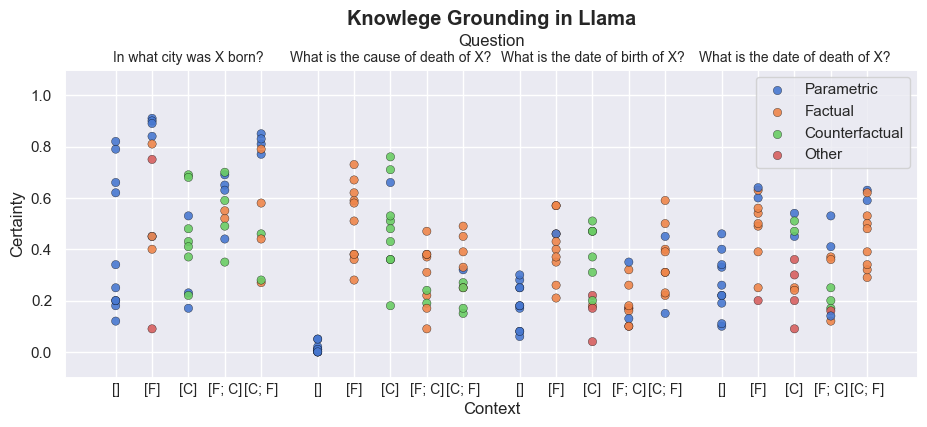

In [8]:
pyplot.rcParams['figure.figsize'] = 11, 4
props = dict(
    alpha = .9,
    linewidths = .25,
    edgecolors = 'black',
)

palette = seaborn.color_palette('muted', 4)
pyplot.scatter(
    questions,
    logits,
    c = [palette[x] for x in colors],
    **props,
)

for e, p in enumerate(categories):
    pyplot.scatter([], [], color = palette[e], label = p, **props)
pyplot.legend()

pyplot.gca().set_ylim(-.1, 1.1)
pyplot.ylabel('Certainty')

pyplot.gca().xaxis.set_major_formatter(FuncFormatter(lambda x, _: things[x]))
pyplot.gca().xaxis.set_major_locator(FixedLocator(list(things.keys())))
pyplot.gca().xaxis.set_tick_params(labelsize = 'small', length = 0)
pyplot.gca().set_xlabel('Context')
pyplot.gca().set_xlim(min(things.keys()) - .25, max(things.keys()) + .25)

q_ax = pyplot.gca().twiny()
q_ax.grid(False)
for loc, name in names.items():
    q_ax.scatter(loc, -10)

q_ax.xaxis.set_major_formatter(FuncFormatter(lambda x, _: names[x]))
q_ax.xaxis.set_major_locator(FixedLocator(list(names.keys())))
q_ax.xaxis.set_tick_params(labelsize = 'small', length = 0)
q_ax.set_xlim(min(things.keys()) - .25, max(things.keys()) + .25)
q_ax.set_xlabel('Question')

pyplot.title('Knowlege Grounding in Llama', fontsize = 'large', fontweight = 'bold')

pyplot.savefig('plots/knowledge_grounding_scatter.png', dpi = 300, bbox_inches = 'tight')
